[View in Colaboratory](https://colab.research.google.com/github/ARBaynes/ai-coursework/blob/master/Machine_Learning_Coursework.ipynb)


# Import statements

In [0]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import seaborn as sns

import urllib2

The models I shall be using for this project include:
*    A LogisticRegression model
*    A RandomForestClassifier (effectively a series of decision trees).

I also considered using a neural network, but ultimately as I have comparably small numbers of data with a large amount of numerical variation, using either Logistic Regression (referred to henceforth simply as `regression`) or a Random Tree (referred to as `tree`) would be a better decision.

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Defining functions

Described below are the general-use functions to be declared at the beginning of the machine learning process (before being used later on).

In [0]:
def percentage(decimal):
  return decimal * 100


def get_grade(score):
    # https://en.wikipedia.org/wiki/Academic_grading_in_Portugal
    if 0 <= score < 3:
        return 0
        # Poor result
    elif 3 <= score < 9:
        return 1
        # Weak result
    elif 9 <= score < 13:
        return 2
        # Sufficient result
    elif 13 <= score < 15:
        return 3
        # Good result
    elif 15 <= score < 17:
        return 4
        # Very good result
    else:
        return 5
        # Excellent result


def get_feature_columns(data):
    cols = data.columns.tolist()
    cols.remove('grade')
    return cols


def get_x(data, columns):
    return data[columns].values


def get_y(data):
    return data['grade'].values


def get_tsne_data(data, _x):
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(_x)
    data_tsne = data.copy(deep=True)
    data_tsne['x-tsne'] = tsne_results[:, 0]
    data_tsne['y-tsne'] = tsne_results[:, 1]
    return data_tsne


def get_clusters(_x):
    km = KMeans(n_clusters=5)
    km.fit(_x)
    return km.predict(_x)

# Importing and describing data

The data is recieved from a [personal Github repository](https://github.com/ARBaynes/ai-coursework), as the UCI Dataset shown [here](https://archive.ics.uci.edu/ml/datasets/student+performance) is wrapped inside of a [.zip folder](https://archive.ics.uci.edu/ml/machine-learning-databases/00320/) (and thus inaccessible via request to the database).

I used only the maths class data (as opposed to using both the maths and portugese class data) as an accurate model of student grades would apply only to the subject the model is provided with.

In [0]:
rq = urllib2.Request('https://raw.githubusercontent.com/ARBaynes/ai-coursework/master/data/student/student-mat.csv')
student_data = pd.read_csv(urllib2.urlopen(rq), sep=';', header=0)

In [270]:
student_data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


This data is a record of 395 students from Portugese maths classes in two schools and the grades they recieved throughout the year. This data can be used to classify students by their personal data into the grades they may recieve.

There are 33 columns to describe, 17 of which require encoding:

*   school
*   sex
*   address
*   famsize
*   Pstatus
*   Mjob
*   Fjob
*   reason
*   guardian
*   schoolsup
*   famsup
*   paid
*   activities
*   nursery
*   higher
*   internet
*   romantic

In [271]:
student_data.G3.describe()

count    395.000000
mean      10.415190
std        4.581443
min        0.000000
25%        8.000000
50%       11.000000
75%       14.000000
max       20.000000
Name: G3, dtype: float64

The most crucial column here for modelling student grades is G3. This column displays the final grade which the student recieved out of 20 ( [the traditional grading boundary for the Portugese school system]((# https://en.wikipedia.org/wiki/Academic_grading_in_Portugal))

With this we can calculate the grade class using the get_grade() function defined above.

# Data pre-processing

In [0]:
sns.set()

student_data = pd.get_dummies(student_data)

student_data['grade'] = student_data['G3'].apply(lambda score: get_grade(score))

In [273]:
student_data.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes,grade
0,18,4,4,2,2,0,4,3,4,1,...,0,0,1,0,1,1,0,1,0,1
1,17,1,1,1,2,0,5,3,3,1,...,0,1,0,0,1,0,1,1,0,1
2,15,1,1,1,2,3,4,3,2,2,...,0,0,1,0,1,0,1,1,0,2
3,15,4,2,1,3,0,3,2,2,1,...,1,0,1,0,1,0,1,0,1,4
4,16,3,3,1,2,0,4,3,2,1,...,0,0,1,0,1,1,0,1,0,2


In [274]:
student_data.shape

(395, 60)

This data pre-processing gets the dummies of the columns which should be encoded as numbers and transforms them into many descriptive columns of 1s and 0s (as opposed to few columns of descriptive entries).

Additionally the student's final grade class is appended to the end of their data entry via a lambda function calling the get_grade() function defined earlier.

# Clustering

In [0]:
feature_columns = get_feature_columns(student_data)
x = get_x(student_data, feature_columns)

clusters = get_clusters(x)

Here you can see that we get the feature columns (all columns without the grades) and the data from them, then pass it to the clustering function.

```python
def get_clusters(_x):
    km = KMeans(n_clusters=5)
    km.fit(_x)
    return km.predict(_x)
  ```
  This will, when passed the values from the feature columns, return 5 clusters of data using the K-Means clustering algorithm. 
  
  The K-Means algorithm will find 5 groups from the data by iteratively assigning each piece of data to one of the clusters based on the similarity of features between other pieces of data.

In [0]:
student_data['cluster'] = clusters

feature_columns = get_feature_columns(student_data)
x = get_x(student_data, feature_columns)
y = get_y(student_data)

The original student data frame must then be appended with the cluster column (to help with classification in the model later on).

Seeing as we change the data frame, we must then change the other variables which rely on that data frame - thus we update both feature_columns and x in order for them to contain the new 'cluster' column. 

After this, we can set up a y column, which returns only the target values (from the 'grades' column).

In [277]:
print(feature_columns)

['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3', 'school_GP', 'school_MS', 'sex_F', 'sex_M', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'schoolsup_no', 'schoolsup_yes', 'famsup_no', 'famsup_yes', 'paid_no', 'paid_yes', 'activities_no', 'activities_yes', 'nursery_no', 'nursery_yes', 'higher_no', 'higher_yes', 'internet_no', 'internet_yes', 'romantic_no', 'romantic_yes', 'cluster']


# Scatter plotting

The below code will pass the students data into the get_tsne_data() function which uses *'t-Distributed Stochastic Neighbor Embedding'* (TSNE) to reduce the dimensions of our data. We have to do this before plotting the data as we have roughly 60 columns of data - far too many to plot on a single dimension scatter plot!

```python
def get_tsne_data(data, _x):
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(_x)
    data_tsne = data.copy(deep=True)
    data_tsne['x-tsne'] = tsne_results[:, 0]
    data_tsne['y-tsne'] = tsne_results[:, 1]
    return data_tsne
  ```

This function uses the built-in `sklearn.manifold.TSNE`  module under the scikitlearn package.

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 395 samples in 0.001s...
[t-SNE] Computed neighbors for 395 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 395 / 395
[t-SNE] Mean sigma: 3.156946
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.280064
[t-SNE] Error after 300 iterations: 0.521067


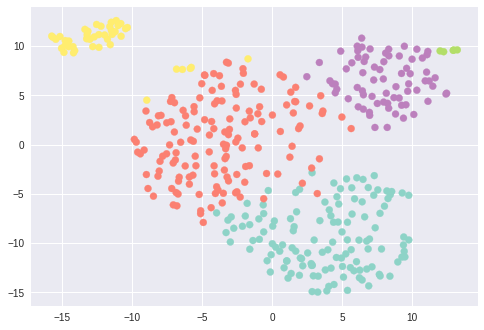

In [278]:
plt.figure(0)

student_tsne = get_tsne_data(student_data, x)
plt.scatter(student_tsne['x-tsne'], student_tsne['y-tsne'], c=clusters, cmap='Set3')

plt.show()

# Parameter tuning

Below we begin parameter tuning, which basically tests out the Logistic Regression model for the best series of parameters to pass it. The parameters we test out include penalty (the type of 'punishment' we give the model if it predicts incorrectly - either l1 or l2) and C (the strength of regularization used to reduce overfitting).

The model will be cross-validated 25 times within each test, then the results output to a plot of each model's accuracies per parameter variation.

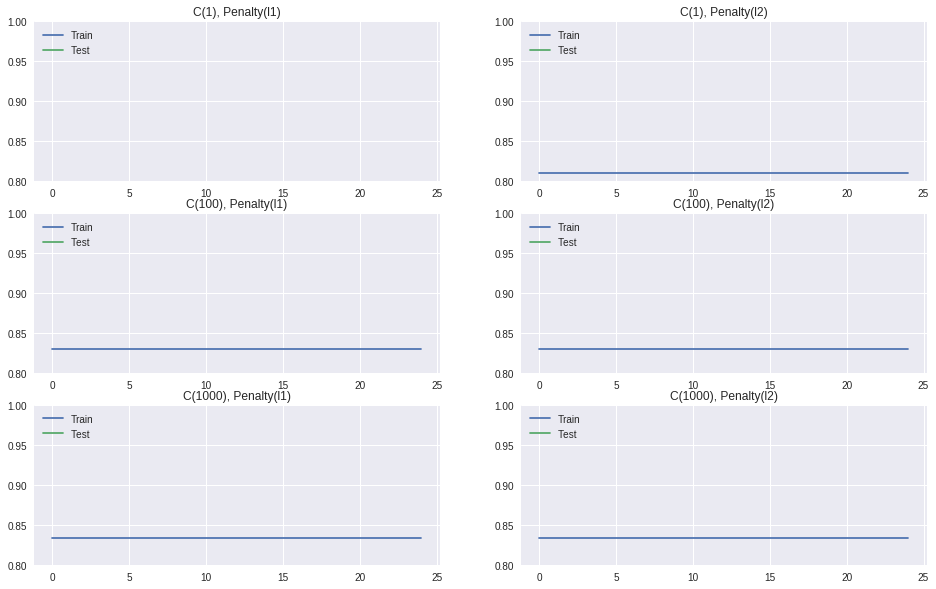

In [279]:
plt.figure(1, figsize=(16, 10))
c_set = [1, 100, 1000]
penalty_set = ['l1', 'l2']
ctr = 1

for ix, c_param in enumerate(c_set):
    for jx, penalty_param in enumerate(penalty_set):
        r_accuracies_train = []
        r_accuracies_test = []
        for i in range(25):
            train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.33, random_state=42)

            regression_model = LogisticRegression(penalty=penalty_param, C=c_param)

            regression_model.fit(train_x, train_y)

            r_accuracies_train.append(regression_model.score(train_x, train_y))
            r_accuracies_test.append(regression_model.score(test_x, test_y))

        plt.subplot(len(c_set), len(penalty_set), ctr)
        ctr += 1

        assert len(r_accuracies_train) == len(r_accuracies_test)

        plt.plot(range(len(r_accuracies_train)), r_accuracies_train, label='Train')
        plt.plot(range(len(r_accuracies_test)), r_accuracies_test, label='Test')

        plt.ylim(0.8, 1.0)

        plt.legend(loc='upper left')
        plt.title("C({}), Penalty({})".format(c_param, penalty_param))

plt.show()


As you can (hopefully) see above, a C variable of 100 and an l1 penalty produce the most consistent model, thus should be used as the parameters for the final fit of the model.

# Cross validation

he cross validation is performed by looping through the model-making process a number of times to find its accuracy when tested against a subset of data.

These results are both printed to the console (for general browsing, but not in a particularly readable/manipulateable way) and stored in a cross validation dataframe (for data manipulation, better viewing, and access to extra pandas functionality).

In [280]:
cv_frame = pd.DataFrame(columns=[
  'TreeTestAccuracy',
  'TreeTrainAccuracy',
  'RegressionTestAccuracy',
  'RegressionTrainAccuracy'
])


for i in range(11):
  # Create testing and training datasets from the previously declared x (feature column values) and y (target column values) variables
  train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.25)
  
  # Set up the models with the tuned parameters
  regression_model = LogisticRegression(penalty='l1', C=100)
  tree_model = RandomForestClassifier(n_estimators=15, max_depth=5)
  
  # Pass the training data into the models
  tree_model.fit(train_x, train_y)
  regression_model.fit(train_x, train_y)
  
  # Calculate the accuracy 'score's for each model by checking against both the training and test data
  # Then save it to a seperate variable as a percentage instead of a decimal (for ease of reading)
  tree_test_score = percentage(tree_model.score(test_x, test_y))
  tree_train_score = percentage(tree_model.score(train_x, train_y))
  regression_test_score = percentage(regression_model.score(test_x, test_y))
  regression_train_score =percentage(regression_model.score(train_x, train_y))
  
  # Print the Tree Test and Regression Test scores
  print('TTe: {}'.format(tree_test_score))
  print('RTe: {}'.format(regression_test_score))

  # Print the Tree Train and Regression Train scores
  print('TTr: {}'.format(tree_train_score))
  print('RTr: {}'.format(regression_train_score))
  
  # Add all of the scores to a new row in the cross validation dataframe
  cv_frame.loc[i] = [
      tree_test_score, 
      tree_train_score, 
      regression_test_score, 
      regression_train_score
  ]
  
  # Repeat until all (minimum 10) loops of cros validation have been completed

TTe: 92.9292929293
RTe: 53.5353535354
TTr: 96.9594594595
RTr: 83.7837837838
TTe: 85.8585858586
RTe: 61.6161616162
TTr: 97.2972972973
RTr: 80.7432432432
TTe: 89.898989899
RTe: 64.6464646465
TTr: 95.2702702703
RTr: 79.7297297297
TTe: 89.898989899
RTe: 59.595959596
TTr: 97.2972972973
RTr: 82.4324324324
TTe: 85.8585858586
RTe: 57.5757575758
TTr: 97.2972972973
RTr: 82.7702702703
TTe: 91.9191919192
RTe: 70.7070707071
TTr: 97.972972973
RTr: 82.0945945946
TTe: 83.8383838384
RTe: 51.5151515152
TTr: 96.9594594595
RTr: 81.4189189189
TTe: 81.8181818182
RTe: 58.5858585859
TTr: 95.6081081081
RTr: 80.7432432432
TTe: 87.8787878788
RTe: 57.5757575758
TTr: 94.9324324324
RTr: 82.7702702703
TTe: 85.8585858586
RTe: 60.6060606061
TTr: 95.9459459459
RTr: 82.0945945946
TTe: 85.8585858586
RTe: 62.6262626263
TTr: 93.2432432432
RTr: 80.0675675676


Below is the cross validation dataframe containing the accuracy scores.

In [281]:

display(cv_frame)

,TreeTestAccuracy,TreeTrainAccuracy,RegressionTestAccuracy,RegressionTrainAccuracy
0,92.929293,96.959459,53.535354,83.783784
1,85.858586,97.297297,61.616162,80.743243
2,89.898990,95.270270,64.646465,79.729730
3,89.898990,97.297297,59.595960,82.432432
4,85.858586,97.297297,57.575758,82.770270
5,91.919192,97.972973,70.707071,82.094595
6,83.838384,96.959459,51.515152,81.418919
7,81.818182,95.608108,58.585859,80.743243
8,87.878788,94.932432,57.575758,82.770270
9,85.858586,95.945946,60.606061,82.094595


Below is the general description for the cross validation dataframe, including the mean accuracy for each column along with the minimum and maximum values.

In [282]:
cv_frame.describe()

,TreeTestAccuracy,TreeTrainAccuracy,RegressionTestAccuracy,RegressionTrainAccuracy
count,11.000000,11.000000,11.000000,11.000000
mean,87.419651,96.253071,59.871442,81.695332
std,3.421355,1.396661,5.230937,1.262431
min,81.818182,93.243243,51.515152,79.729730
25%,85.858586,95.439189,57.575758,80.743243
50%,85.858586,96.959459,59.595960,82.094595
75%,89.898990,97.297297,62.121212,82.601351
max,92.929293,97.972973,70.707071,83.783784


# Plotting the model accuracies

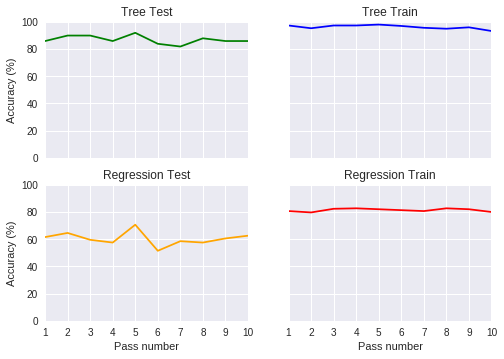

In [283]:
plt.figure(2)

f, axarr = plt.subplots(2, 2, sharex='all')

axarr[0, 0].set_title('Tree Test')
axarr[0, 0].axis([1, 10, 0, 100])
axarr[0, 0].xaxis.set_major_locator(MaxNLocator(integer=True))

axarr[0, 1].set_title('Tree Train')
axarr[0, 1].axis([1, 10, 0, 100])
axarr[0, 1].xaxis.set_major_locator(MaxNLocator(integer=True))

axarr[1, 0].set_title('Regression Test')
axarr[1, 0].axis([1, 10, 0, 100])
axarr[1, 0].xaxis.set_major_locator(MaxNLocator(integer=True))

axarr[1, 1].set_title('Regression Train')
axarr[1, 1].axis([1, 10, 0, 100])
axarr[1, 1].xaxis.set_major_locator(MaxNLocator(integer=True))

for ax in axarr.flat:
    ax.set(xlabel='Pass number', ylabel='Accuracy (%)')
for ax in axarr.flat:
    ax.label_outer()

axarr[0, 0].plot(
    cv_frame['TreeTestAccuracy'].get_values(),
    color='green'
)
axarr[0, 1].plot(
    cv_frame['TreeTrainAccuracy'].get_values(),
    color='blue'
)
axarr[1, 0].plot(
    cv_frame['RegressionTestAccuracy'].get_values(),
    color='orange'
)
axarr[1, 1].plot(
    cv_frame['RegressionTrainAccuracy'].get_values(),
    color='red'
)

plt.show()

So to begin an analysis, we can ignore both Training tables. This is because validating a model against the data which it was passed anyway somewhat defeats the purpose of validating it as a whole, but it is still interesting to see the results of it - that the Tree model is still more consistently accurate than the Regression model.

As you can (hopefully) see when looking at only the Regression and Tree Test graphs, the Regression Test yields rather terrible results in comparison to the results of the Tree Test. 

This is likely because the dataset is very small (only 395 entries), and the Logistic Regression algorithm cannot perform fully with such a small set of data. If more data was to be gathered (consistent to the grading and subject), then the Logistic Regression model may be more adviseable. 

For now - with such a small dataset - a Random Forest Classifier Model appears to be most accurate and most robust. This is why I more highly recommended this model, as opposed to the Logistic Regression Model, for the current use (analysing small groups of data with a fairly large number of columns).